# Proyek Klasifikasi Gambar: [Food Classification dataset](http://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset)
- **Nama:** Bela Ismawati Nuraisa
- **Email:** belaismawati292@gmail.com
- **ID Dicoding:** @belaismawati

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from IPython.display import FileLink

## Data Preparation

### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_dir = '/content/drive/My Drive/Proyek Klasifikasi Gambar/Food Classification dataset'
# dataset_dir = '/kaggle/input/food-classification-dataset/Food Classification dataset'
print("Jumlah file dalam dataset:", len(os.listdir(dataset_dir)))

Jumlah file dalam dataset: 7


In [4]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_dir)

Crispy Chicken: 1500
- (178, 283)
- (204, 247)
- (206, 244)
- (225, 224)
- (328, 154)
- (190, 266)
- (360, 140)
- (200, 252)
- (177, 284)
- (201, 251)
- (186, 271)
- (187, 270)
- (189, 267)
- (276, 183)
- (199, 253)
- (254, 198)
- (259, 194)
- (185, 272)
- (280, 180)
- (174, 290)
- (197, 255)
- (266, 190)
- (267, 189)
- (252, 200)
- (272, 185)
- (257, 196)
- (287, 176)
- (166, 304)
- (247, 204)
- (220, 220)
- (212, 237)
- (279, 181)
- (284, 177)
- (184, 273)
- (299, 168)
- (256, 197)
- (343, 147)
- (262, 192)
- (290, 174)
- (211, 238)
- (291, 173)
- (246, 205)
- (251, 201)
- (245, 206)
- (309, 163)
- (269, 188)
- (298, 169)
- (181, 279)
- (260, 194)
- (244, 207)
- (316, 159)
- (249, 203)
- (215, 235)
- (250, 202)
- (234, 215)
- (308, 164)
- (376, 134)
- (348, 145)
- (345, 146)
- (293, 172)
- (318, 159)
- (248, 204)
- (230, 220)
- (237, 213)
- (312, 161)
- (192, 263)
- (161, 312)
- (322, 156)
- (179, 281)
- (310, 163)
- (353, 143)
- (188, 268)
- (191, 264)
- (320, 158)
- (221, 228)
- (3

### Data Preprocessing

#### Split Dataset

- Membagi dataset dan menyimpannya di folder tiap subset

In [5]:
split_dir = '/content/drive/My Drive/Proyek Klasifikasi Gambar'
# split_dir = '/kaggle/working/'
image_dict = defaultdict(list)

for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
      continue

    images = sorted([filename for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])
    image_dict[class_name].extend(images)

# Mengonversi ke bentuk list
images, labels = [], []
for class_name, image_list in image_dict.items():
  for image in image_list:
    images.append(image)
    labels.append(class_name)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Buat folder train, val, test berdasarkan label folder asli
for subset in ["train", "val", "test"]:
    for label in image_dict.keys():
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

# Fungsi pemindahan file berdasarkan kategori folder asli
def move_files(image_list, label_list, subset_name):
    for image, label in zip(image_list, label_list):
        source_path = os.path.join(dataset_dir, label, image)
        destination_path = os.path.join(split_dir, subset_name, label, image)
        shutil.copy(source_path, destination_path)

# Pindahkan ke folder berdasarkan stratified split
move_files(X_train, y_train, "train")
move_files(X_val, y_val, "val")
move_files(X_test, y_test, "test")

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 8446 | Val: 1056 | Test: 1056


- Load data train, val, dan test yang telah dibagi

In [6]:
train_dir = '/content/drive/My Drive/Proyek Klasifikasi Gambar/train'
val_dir = '/content/drive/My Drive/Proyek Klasifikasi Gambar/val'
test_dir = '/content/drive/My Drive/Proyek Klasifikasi Gambar/test'

['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taquito']


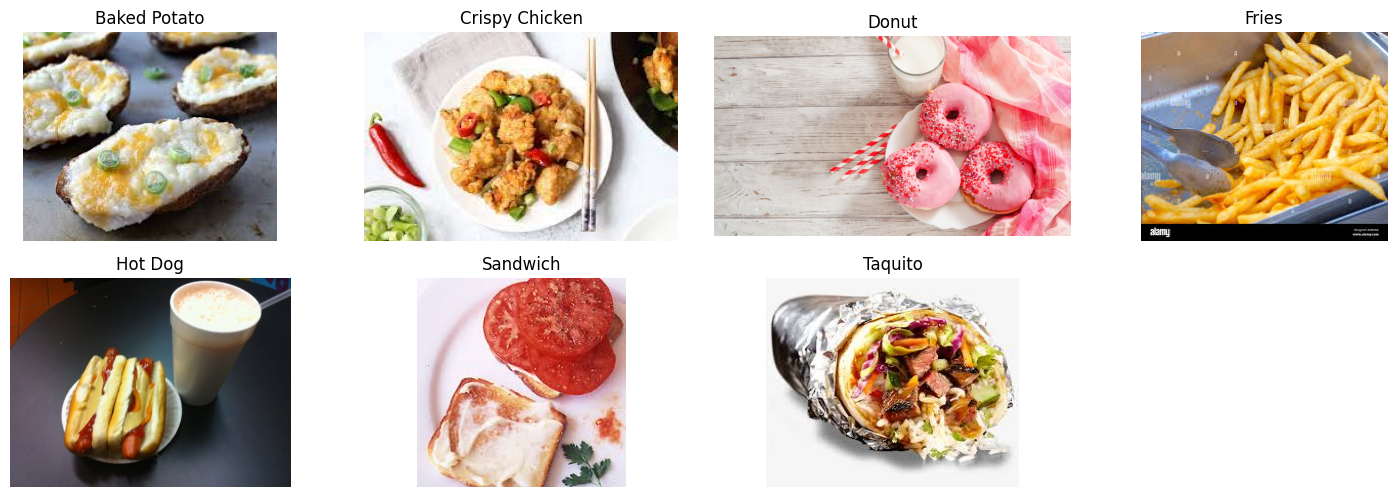

In [7]:
image_dict = defaultdict(list)

for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
      continue

    images = sorted([filename for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])
    image_dict[class_name].extend(images)

# Mengonversi ke bentuk list
images, labels = [], []
for class_name, image_list in image_dict.items():
  for image in image_list:
    images.append(image)
    labels.append(class_name)

class_names = sorted(image_dict.keys())
print(class_names)

plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    class_train_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_train_path) and os.listdir(class_train_path):
        first_image = sorted(os.listdir(class_train_path))[0]
        image_path = os.path.join(class_train_path, first_image)
        image = plt.imread(image_path)
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Fungsi untuk mengubah format gambar ke RGB
def convert_to_rgb(folder_dir):
    images = []
    for class_name in os.listdir(folder_dir):
        class_path = os.path.join(folder_dir, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                try:
                    img = Image.open(img_path)
                    if img.mode != "RGB":
                        img = img.convert("RGB")
                        img.save(img_path)
                        print(f"{img_name} dikonversi ke RGB")
                except Exception as e:
                    print(f"Error pada {img_name}: {e}")

convert_to_rgb(train_dir)
convert_to_rgb(val_dir)
convert_to_rgb(test_dir)

Donut (34).png dikonversi ke RGB
Donut (30).png dikonversi ke RGB
Donut (38).png dikonversi ke RGB
Donut (32).png dikonversi ke RGB
Donut (12).png dikonversi ke RGB
Donut (13).png dikonversi ke RGB
Donut (23).png dikonversi ke RGB
Donut (33).png dikonversi ke RGB
Donut (19).png dikonversi ke RGB
Donut (37).png dikonversi ke RGB
Donut (40).png dikonversi ke RGB
Donut (35).png dikonversi ke RGB
Donut (2).png dikonversi ke RGB


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Hot Dog - Train (17).png dikonversi ke RGB
Hot Dog - Train (10).png dikonversi ke RGB
Hot Dog - Train (9).png dikonversi ke RGB
Hot Dog - Train (13).png dikonversi ke RGB
Hot Dog - Train (15).png dikonversi ke RGB
Hot Dog - Train (5).png dikonversi ke RGB
Hot Dog - Train (12).png dikonversi ke RGB
Hot Dog - Train (8).png dikonversi ke RGB
Donut (18).png dikonversi ke RGB
Donut (24).png dikonversi ke RGB
Hot Dog - Train (14).png dikonversi ke RGB
Hot Dog - Train (3).png dikonversi ke RGB
Hot Dog - Train (4).png dikonversi ke RGB
Hot Dog - Train (7).png dikonversi ke RGB
Hot Dog - Train (6).png dikonversi ke RGB


In [9]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               brightness_range=[0.5, 1.5])

val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(train_dir,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=True)

val_generator = val_gen.flow_from_directory(val_dir,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical",
                                            shuffle=False)

test_generator = test_gen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical",
                                             shuffle=False)

Found 8446 images belonging to 7 classes.
Found 1056 images belonging to 7 classes.
Found 1056 images belonging to 7 classes.


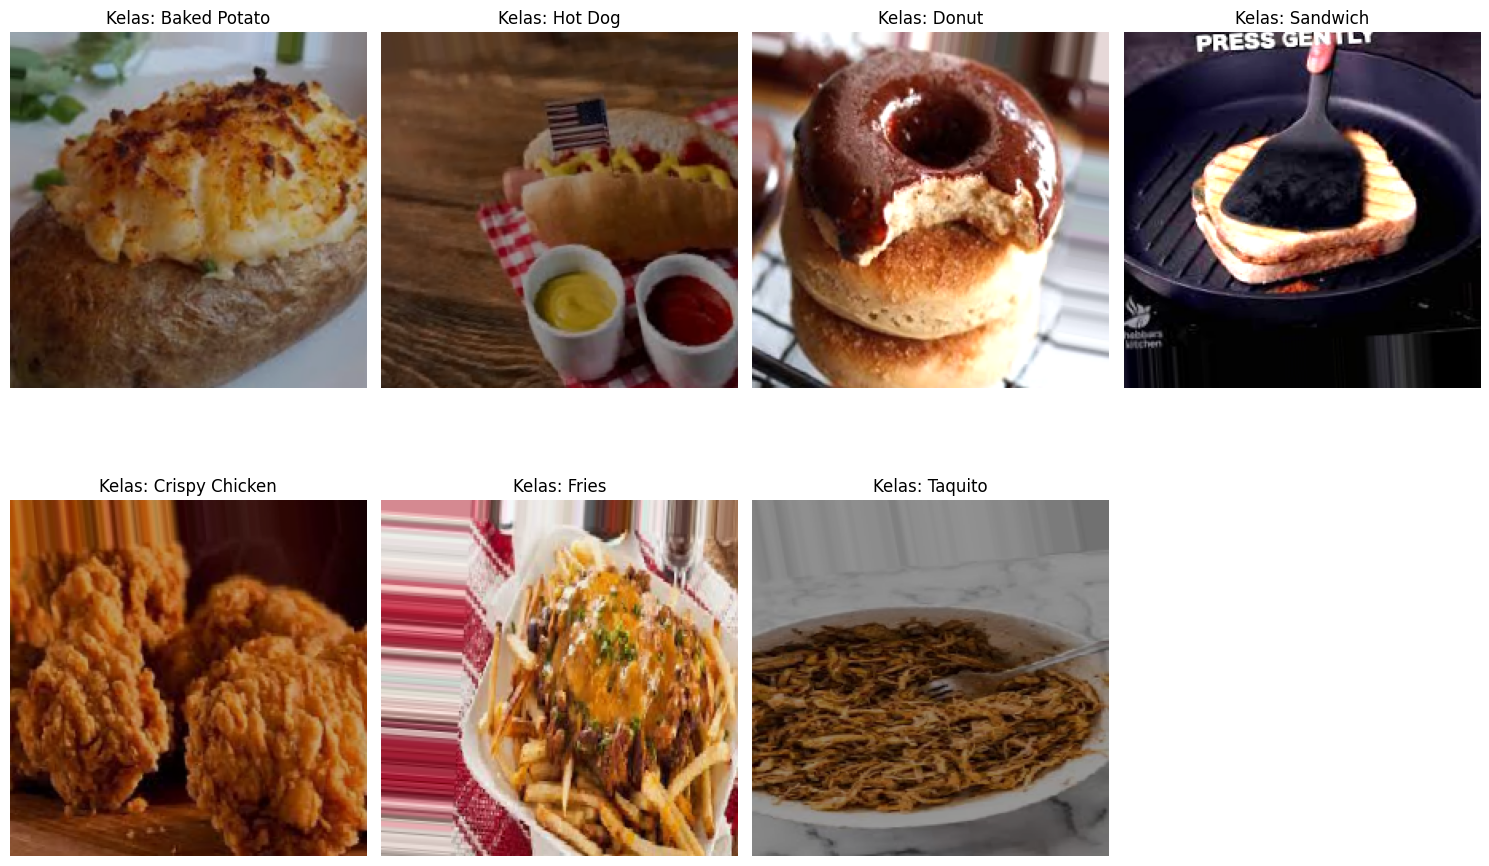

In [10]:
images, labels = next(iter(train_generator)) # Mengambil satu batch (default batch_size=32)
class_name_dict = train_generator.class_indices
inverse_class_name_dict = {value:key for key,value in class_name_dict.items()}

# Menyimpan index dari setiap kelas
shown_classes = set()
selected_indices = []

for i in range(len(labels)):
  label = np.argmax(labels[i])

  if label not in shown_classes:
    selected_indices.append(i)
    shown_classes.add(label)
  if len(shown_classes) == len(inverse_class_name_dict):
    break

# Tampilkan beberapa gambar dalam batch
plt.figure(figsize=(15, 10))
for i, image in enumerate(selected_indices):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[image])
    label_image = np.argmax(labels[image])
    label_name = inverse_class_name_dict[label_image]
    plt.axis("off")
    plt.title(f"Kelas: {label_name}")

plt.tight_layout()
plt.show()

## Modelling

In [16]:
# Mengambil Feauture dari model pre-trained
pre_train_model = MobileNetV2(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224,3))

for layer in pre_train_model.layers:
    layer.trainable = False

# Membuat Arsitektur Model
model = tf.keras.models.Sequential([
        pre_train_model,
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D((2,2)),

        # tf.keras.layers.DepthwiseConv2D((3,3), padding='same'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')])

# Melakukan kompilasi Model
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,288,519 (12.54 MB)

 Trainable params: 1,030,535 (3.93 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
def callback():
    callbacks = []

    # ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(filepath='best_model.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min',
                                verbose=1)

    callbacks.append(checkpoint_callback)

    # ReduceLROnPlateau callback
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.3,
                                           patience=7,
                                           verbose=1,
                                           mode='auto',
                                           epsilon=0.0001,
                                           cooldown=1,
                                           min_lr=0.000001)

    callbacks.append(reduce_lr_callback)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   patience=10,
                                   min_delta=0.001,
                                   mode='max',
                                   restore_best_weights=True,
                                   verbose=1)

    callbacks.append(early_stopping)

    return callbacks

In [18]:
callbacks = callback()

# Latih Modelnya
history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=len(train_generator),
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[callbacks])

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.2794 - loss: 1.7641
Epoch 1: val_loss improved from inf to 0.70407, saving model to best_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 180s 625ms/step - accuracy: 0.2800 - loss: 1.7630 - val_accuracy: 0.7822 - val_loss: 0.7041 - learning_rate: 1.0000e-04
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.7041 - loss: 0.9062
Epoch 2: val_loss improved from 0.70407 to 0.58884, saving model to best_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 151s 573ms/step - accuracy: 0.7042 - loss: 0.9060 - val_accuracy: 0.8030 - val_loss: 0.5888 - learning_rate: 1.0000e-04
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7683 - loss: 0.7186
Epoch 3: val_loss improved from 0.58884 to 0.47858, saving model to best_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 153s 578ms/step - accuracy: 0.7683 - loss: 0.7185 - val_accuracy: 0.8428 - val_loss: 0.4786 - learning_rate: 1.0000e-04
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7953 - loss: 0.6492
Epoch 4: val_loss improved from 0.47858 to 0.45287, saving model to best_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 197s 561ms/step - accuracy: 0.7954 - loss: 0.6491 - val_accuracy: 0.8456 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8226 - loss: 0.5686
Epoch 5: val_loss did not improve from 0.45287
264/264 ━━━━━━━━━━━━━━━━━━━━ 202s 561ms/step - accuracy: 0.8226 - loss: 0.5686 - val_accuracy: 0.8523 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8271 - loss: 0.5698
Epoch 6: val_loss did not improve from 0.45287
264/264 ━━━━━━━━━━━━━━━━━━━━ 203s 566ms/step - accuracy: 0.8271 - loss: 0.5697 - val_accuracy: 0.8466 - val_loss: 0.4663 - learning_rate: 1.0000e-04
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.8372 - loss: 0.5291
Epoch 7: val_loss did not improve from 0.45287
264/264 ━━━━━━━━━━━━━━━━━━━━ 201s 564ms/step - accuracy: 0.8372 - loss: 0.5291 - val_accuracy: 0.8589 - val_loss: 0.4661 - learning_rate: 1.0000e-04

264/264 ━━━━━━━━━━━━━━━━━━━━ 201s 561ms/step - accuracy: 0.8365 - loss: 0.5237 - val_accuracy: 0.8703 - val_loss: 0.4223 - learning_rate: 1.0000e-04
Epoch 9/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8627 - loss: 0.4646
Epoch 9: val_loss improved from 0.42234 to 0.42134, saving model to best_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 202s 562ms/step - accuracy: 0.8627 - loss: 0.4646 - val_accuracy: 0.8769 - val_loss: 0.4213 - learning_rate: 1.0000e-04
Epoch 10/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8676 - loss: 0.4347
Epoch 10: val_loss did not improve from 0.42134
264/264 ━━━━━━━━━━━━━━━━━━━━ 157s 596ms/step - accuracy: 0.8676 - loss: 0.4347 - val_accuracy: 0.8674 - val_loss: 0.4393 - learning_rate: 1.0000e-04
Epoch 11/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8707 - loss: 0.4410
Epoch 11: val_loss did not improve from 0.42134
264/264 ━━━━━━━━━━━━━━━━━━━━ 151s 573ms/step - accuracy: 0.8707 - loss: 0.4410 - val_accuracy: 0.8655 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 12/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8652 - loss: 0.4366
Epoch 12: val_loss did not improve from 0.42134
264/264 ━━━━━━━━━━━━━━━━━━━━ 198s 560ms/step - accuracy: 0.8652 - loss: 0.4366 - val_accuracy: 0.8580 - val_loss: 0.4742 - learning_rate: 1.00

264/264 ━━━━━━━━━━━━━━━━━━━━ 202s 573ms/step - accuracy: 0.9066 - loss: 0.3098 - val_accuracy: 0.8759 - val_loss: 0.4129 - learning_rate: 3.0000e-05
Epoch 20/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9095 - loss: 0.2999
Epoch 20: val_loss did not improve from 0.41289
264/264 ━━━━━━━━━━━━━━━━━━━━ 151s 570ms/step - accuracy: 0.9095 - loss: 0.2999 - val_accuracy: 0.8769 - val_loss: 0.4354 - learning_rate: 3.0000e-05
Epoch 21/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9116 - loss: 0.2895
Epoch 21: val_loss did not improve from 0.41289
264/264 ━━━━━━━━━━━━━━━━━━━━ 200s 562ms/step - accuracy: 0.9116 - loss: 0.2896 - val_accuracy: 0.8778 - val_loss: 0.4363 - learning_rate: 3.0000e-05
Epoch 22/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9173 - loss: 0.2825
Epoch 22: val_loss did not improve from 0.41289
264/264 ━━━━━━━━━━━━━━━━━━━━ 201s 560ms/step - accuracy: 0.9173 - loss: 0.2825 - val_accuracy: 0.8816 - val_loss: 0.4465 - learning_rate: 3.00

## Evaluasi dan Visualisasi

In [19]:
# Mengevalusasi Model dengan Data Uji
loss, acc = model.evaluate(test_generator)
print(f'Hasil Akurasi model adalah {acc:.3f} dengan loss {loss:.3f} pada data uji')

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8689 - loss: 0.4651
Hasil Akurasi model adalah 0.863 dengan loss 0.508 pada data uji


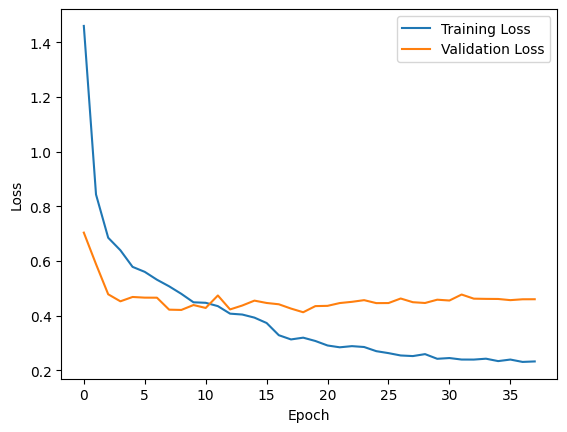

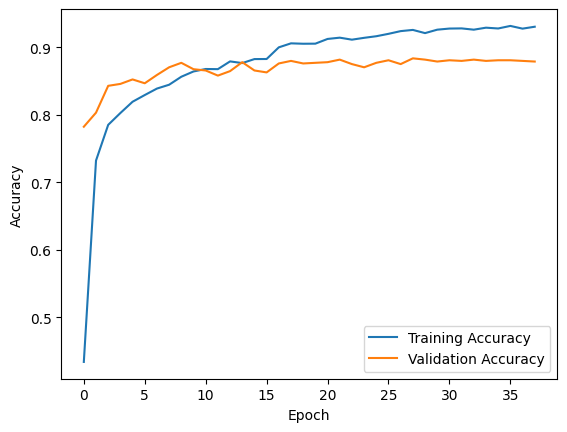

In [20]:
def plot_evaluation_model(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epoch = len(loss)

  plt.figure()
  plt.plot(range(epoch), loss, label='Training Loss')
  plt.plot(range(epoch), val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(range(epoch), acc, label='Training Accuracy')
  plt.plot(range(epoch), val_acc, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

# Visualisasi Akurasi dan Loss
plot_evaluation_model(history)

In [21]:
class_name_dict = test_generator.class_indices
inverse_class_name_dict = {value: key for key, value in class_name_dict.items()}

# Melakukan prediksi
predictions = model.predict(test_generator)
predicted_classes = [np.argmax(predict) for predict in predictions]
predicted_labels = [inverse_class_name_dict[label] for label in predicted_classes]

actual_class_name = [inverse_class_name_dict[idx] for idx in test_generator.classes]

# Menyimpan hasil prediksi ke dalam CSV
result = pd.DataFrame({'Actual label': actual_class_name, 'Predicted label': predicted_labels})
result.to_csv('hasil_prediksi.csv', index=False)

# Menampilkan beberapa hasil prediksi
for i in range(10):
    print(f'Actual: {actual_class_name[i]}, Predicted: {predicted_labels[i]}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Crispy Chicken
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato
Actual: Baked Potato, Predicted: Baked Potato


Classification Report:
                 precision    recall  f1-score   support

  Baked Potato       0.82      0.86      0.84       150
Crispy Chicken       0.86      0.85      0.86       150
         Donut       0.92      0.93      0.92       151
         Fries       0.90      0.85      0.88       150
       Hot Dog       0.85      0.88      0.86       155
      Sandwich       0.88      0.85      0.86       150
       Taquito       0.81      0.82      0.82       150

      accuracy                           0.86      1056
     macro avg       0.86      0.86      0.86      1056
  weighted avg       0.86      0.86      0.86      1056



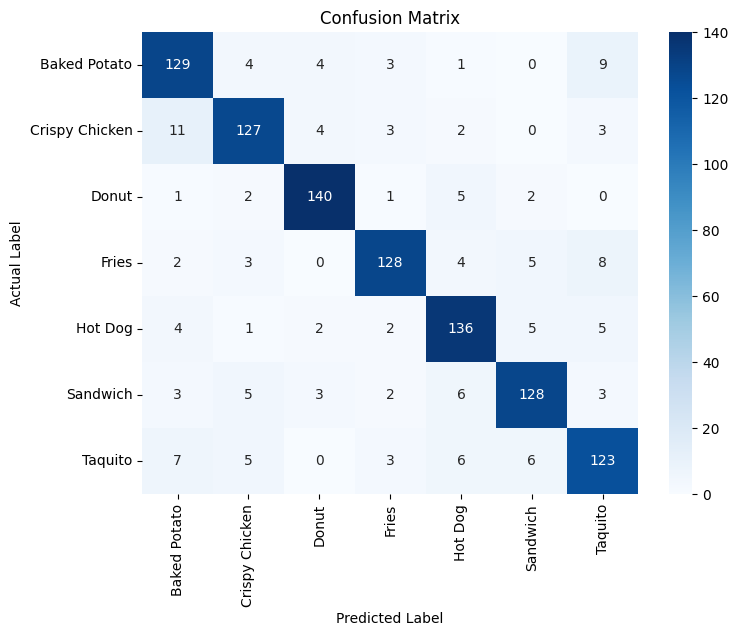

In [22]:
classif_report = classification_report(actual_class_name, predicted_labels)

conf_matrix = confusion_matrix(actual_class_name, predicted_labels)

print('Classification Report:\n', classif_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,
            fmt='d', cmap='Blues',
            xticklabels=class_name_dict,
            yticklabels=class_name_dict)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [23]:
# Menyimpan model dalam format .h5
model.save('model_food_classification.h5')

* **Konversi ke SavedModel**

In [24]:
# Load model dari format .h5
model = load_model('model_food_classification.h5')

# Mengubah format model ke SavedModel
tf.saved_model.save(model, 'my_model/')

In [25]:
print(os.listdir('my_model/'))

['fingerprint.pb', 'assets', 'saved_model.pb', 'variables']


In [26]:
# Kompres folder my_model/ menjadi .zip
shutil.make_archive("my_model", 'zip', "my_model")

# Menampilkan link untuk mengunduh file zip-nya
FileLink("my_model.zip")

/content/my_model.zip

* **Konversi model ke format TF-Lite**

In [27]:
model = tf.saved_model.load("my_model")
print(model.signatures)

_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 7), dtype=tf.float32, name='output_0')]] at 0x7D5475E8D490>})


In [28]:
# Konversi ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("my_model")
tflite_model = converter.convert()

# Simpan ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [30]:
# Buat konten yang akan ditulis ke dalam file
content = """Baked Potato
Crispy Chicken
Donut
Fries
Hot Dog
Sandwich
Taco
Taquito"""

# Tentukan path dan nama file
file_path = "klasifikasiGambar.txt"

# Tulis konten ke dalam file
with open(file_path, "w") as file:
    file.write(content)

In [31]:
# Menampilkan link untuk mengunduh model
FileLink('model.tflite')

/content/model.tflite

* **Konversi model ke TFJS**

In [32]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [33]:
# Konversi dari direktori SavedModel
!tensorflowjs_converter --input_format=tf_saved_model my_model/ tfjs_model/

2025-06-17 07:11:35.141072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750144295.191291   55373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750144295.209545   55373 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-17 07:11:47.443164: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1750144307.443378   55373 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [34]:
print("Detected GPUs:", tf.config.list_physical_devices('GPU'))

Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:

# Kompres folder
shutil.make_archive("tfjs_model", 'zip', "tfjs_model")

# Menampilkan link untuk mengunduh file zip-nya
FileLink("tfjs_model.zip")

/content/tfjs_model.zip

## Inference (Optional)

In [36]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

In [37]:
# Load SavedModel
model_dir = 'my_model/'
loaded_model = tf.saved_model.load(model_dir)
inference_fn = loaded_model.signatures['serving_default']
# print(loaded_model.signatures.keys())

In [38]:
target_size = (224, 224)
image_path = "Crispy Chicken.jpg"

def preprocessing_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB').resize(target_size)
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    return img

# Memproses gambar
image = preprocessing_image(image_path)

# Konversi ke tensor dan melakukan prediksi
batch_tensor = tf.convert_to_tensor(image)
result = inference_fn(batch_tensor)
# print(result.keys())

predictions = list(result.values())[0]
# predictions = model.predict(batch_tensor)

# Map labels sesuai urutan class
map_labels = {0: 'Baked Potato',
              1: 'Crispy Chicken',
              2: 'Donut',
              3: 'Fries',
              4: 'Hot Dog',
              5: 'Sandwich',
              6: 'Taco',
              7: 'Taquito'}

# Menampilkan hasil prediksi
for i, prediction in enumerate(predictions):
    predicted_class = tf.argmax(prediction).numpy()
    predicted_label = map_labels[predicted_class]
    print(f"Prediksi: {predicted_label}")

Prediksi: Crispy Chicken


In [39]:
tf.keras.backend.clear_session()